# Experiments with Bluetooth Low Energy Beacon Signals

## Imports

In [1]:
# Enable inline Matplotlib
%matplotlib inline

## Imports ##
# JSON
import json

# NumPy
import numpy as np

# Pandas
import pandas as pd
pd.plotting.register_matplotlib_converters()
pd.set_option('display.min_rows', 100)
pd.set_option('display.max_rows', 200)

# Matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D 

# SciPy
from scipy import stats

# seaborn
import seaborn as sns
sns.set_style("whitegrid")
sns.despine()

# scikit-learn
import sklearn
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR, NuSVR
from sklearn.model_selection import GridSearchCV, StratifiedKFold, cross_validate, cross_val_score, cross_val_predict, train_test_split
from sklearn.metrics import make_scorer, explained_variance_score, max_error, mean_absolute_error, mean_squared_error, median_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, scale, minmax_scale, robust_scale, PolynomialFeatures
from sklearn.neighbors import KNeighborsRegressor
import joblib

<Figure size 432x288 with 0 Axes>

## Constants and Helper Functions

In [2]:
# Constant that indicated how long each captured beacon be considered to be present (value in milliseconds).
# This effect can be simulated by a running average window over the collected data.
beacons_inactivity_timer=5000
# Constant that indicates how often the device reports about the surrounding beacons (value in milliseconds). 
# This effect can be simulated by resampling the collected data.  
beacons_refresh_interval=1000

# A function that receives the path to a JSON file containing a data collection run to load that file.
# It also receives a few extra to append to the loaded data which characterize the objective of the loaded data, i.e.:
# - The "target beacons" that we were interested in during the data collection phase.
# - The distance that those target beacons were from the data collection point.
def log_loader(file_path, target_beacons, distance):
    with open(file_path) as json_file:
        log = json.load(json_file)
        log['target_beacons'] = target_beacons
        log['distance'] = distance   
        return log

# This function receives a loaded of logs (see previous function), iterates over them, and unrolls them into a DataFrame.
def convert_logs_to_dataframe(logs):
    # List of per log intermediary DataFrames.
    dfs = []
    # Iterate over each log.
    for log in logs:
        # List of lists that represent a table that will be converted into a DataFrame.
        table = []
        # Iterate over the list of target beacons.
        for beacon in log['target_beacons']:
            # Iterate over the logging sessions contained within a log file.
            for entries in log['sessions'].values():
                # Iterate over the entries of each of those sessions.
                for entry in entries:
                    # Get each of the readings in the the entry.
                    reading = entry['reading']
                    # Check if the reading matches our target iBeacon.
                    if reading['type'] == 'iBeacon' and reading['values'][0] == beacon['uuid']\
                    and reading['values'][1] == beacon['major'] and reading['values'][2] == beacon['minor']:
                        # If so extract all the information into and append as row in the table
                        table.append([log['name'],
                                      pd.to_datetime(log['timestamp'], unit='ms'),
                                      entry['id'],
                                      reading['id'],
                                      reading['type'],
                                      str(reading['values']),
                                      reading['values'][0],
                                      reading['values'][1],
                                      reading['values'][2],
                                      reading['txPower'],
                                      reading['rssi'],
                                      pd.to_datetime(reading['timestamp'], unit='ms'),
                                      reading['avgRssi'],
                                      log['distance']])
        
        # After collection everything of interest in the log file into a plain "list of lists",
        # convert into a DataFrame by specifying the column names
        df = pd.DataFrame(table, columns=['filename',
                                          'creationTimestamp',
                                          'entry',
                                          'id',
                                          'type',
                                          'values',
                                          'uuid',
                                          'major',
                                          'minor',
                                          'txPower',
                                          'rssi',
                                          'timestamp',
                                          'avgRssi',
                                          'distance'])
        # If for some reason there are duplicate timestamps on a log file drop them.
        df.drop_duplicates(subset=['timestamp'], inplace=True)
        # Append the DataFrame to the list of DataFrames.
        dfs.append(df)
    # Return the single DataFrame that results from the concatenation of the individual DataFrames.
    # Also reset the index and select only the relevant columns.
    return pd.concat(dfs, ignore_index=True)[['timestamp','values', 'distance', 'rssi', 'avgRssi']]

# A function that should be applied per each device/distance combo, assuming that this corresponds to one and only one of
# the previously loaded log files.
def per_group(d):
    # Compute the difference between the current and previous sample
    d['timestamp_diff'] = d['timestamp'].diff()
    # Use the inverse of the zscore as the weight for each of the samples
    d['weight'] = 1 / (np.abs(stats.zscore(d['rssi'])) + 1)
    # However, the z-score result can be 0 so 1/0 will result in infinity. We need to replace those values by something else.
    # For now, we simply indentify what is the largest value other than infinity and set all the instances of infinity by
    # a number that is slightly larger than that (1% to be exact).
    d.replace(np.inf, d.loc[d.weight != np.inf, 'weight'].max()*1.01, inplace=True)
    # Calculate a running average over the RSSI values to filter out undesired signal strength fluctuation. 
    # In practive, this type of filtering needs to reach a trade-off between stopping abrupt signal changes and 
    # responsiveness to user moveiment.
    d['rolling_mean_rssi'] = d[['timestamp', 'rssi']].rolling(pd.Timedelta(beacons_inactivity_timer, unit='ms'), on='timestamp')['rssi'].mean()
    # Return the DataFrame slice to be merged with all the others.
    return d

# A function that can be used to resample a dataframe according to a given sample interval.
def resample_group(d, sample_interval=beacons_refresh_interval):
    # Change the index to the timestamp column, resample according to the provided sample interval with the desired options (read pandas documentation for details).
    r = d.set_index('timestamp', verify_integrity=True).resample(pd.Timedelta(sample_interval, unit='ms'), label='right', closed='right').pad()
    # Copy the index column to a new column
    r['timestamp_diff'] = r.index
    # Use that new column to store the difference between each row, thus allowing us to check if the resampling process was sucessfully made as desired.
    r['timestamp_diff'] = r['timestamp_diff'].diff()
    return r

## Load Data

In [3]:
# Load Data
# Generate the list of distances at which we collected samples (i.e., 0 to 10 meters in 0.5 meters intervals)
distances = np.linspace(0,10,21)
# A dictionary that describes our data collection task.
collections = {
    # A laptop
    'laptop': {
        # collected samples at theses distances
        'distances': distances,
        # from the following targets:
        'targets': [{ 'uuid': '113069EC-6E64-4BD3-6810-DE01B36E8A3E', 'major': 1, 'minor': 102 }]
    },
    # A smartphone
    'smartphone':  {
        # collected samples at these distances
        'distances': distances,
        # from the following targets:
        'targets': [{ 'uuid': '113069EC-6E64-4BD3-6810-DE01B36E8A3E', 'major': 1, 'minor': 101 }]
    }
}

# Initialize a dictionary that will store the dataframes for each of the devices, indexed by the device name.
tables = {}
# Iterate over the data collection task defined above
for name, device in collections.items():
    # Initialize a list to collect the logs for each of the distances.
    logs = []
    # Iterate over each of the distances collected for the device.
    for d in device['distances']:
        # Load the corresponding file based on the following pattern
        logs.append(log_loader('data/beacons/'+name+'/beacons-'+str(d)+'.json', device['targets'], d))
    # Conver the list of logs to a DataFrame and story in the tables dictionary indexed by the device name.
    tables[name] = convert_logs_to_dataframe(logs)
    # Add a column to the DataFrame which identifies each of each lines as belonging to a certain device.
    tables[name]['device'] = name

# Concatenate the DataFrames for each device into a single DataFrame (recreate the index while at it).
data = pd.concat(tables.values(), ignore_index=True)
# Group the data by Device and Distance, apply the "per_collector_device_distance" function.
# NOTE: This is needed to perform a few extra computations for each of the logging sessions. I could have probably done this
# while loading the data but I decided to keep things separate. However, this may need to be changed if in the future
# grouping turns out not to be enough to slice the data on "per log" basis.
data = data.groupby(['device','distance']).apply(per_group).reset_index(drop=True)

# Just setting some proximity labels based on distance.
# This may be useful if we end up deciding that classification is better than regression for our use case.
# The labels are open to discussion, but these distances are based on Edward T. Hall proxemics theory:
# - https://en.wikipedia.org/wiki/Proxemics#/media/File:Personal_Space.svg
data.loc[data.distance <= 0.4572, 'proximity'] = 'intimate_space'
data.loc[(data['distance'] > 0.4572) & (data['distance'] <= 1.2192), 'proximity'] = 'personal_space'
data.loc[(data['distance'] > 1.2192) & (data['distance'] <= 3.6576), 'proximity'] = 'social_space'
data.loc[(data['distance'] > 3.6576) & (data['distance'] <= 7.62), 'proximity'] = 'public_space'
data.loc[data['distance'] > 7.62, 'proximity'] = 'far_away'

# TODO: 
# Since data is already being saved to CSV/Excel below, perhaps we could check if the files are present before loading 
# data from the JSON logs thus avoiding the repeatition of this loading process each time the notebook is opened.

# Save the DataFrame to a CSV file.
data.to_csv('out/beacons.csv')
# Save the DataFrame to an Excel file
data.to_excel('out/beacons.xlsx')
# Display the DataFrame
data

,timestamp,values,distance,rssi,avgRssi,device,timestamp_diff,weight,rolling_mean_rssi,proximity
0,2019-10-03 12:57:22.098,"['113069EC-6E64-4BD3-6810-DE01B36E8A3E', 1, 102]",0.0,-56,-56.000000,laptop,NaT,0.413058,-56.000000,intimate_space
1,2019-10-03 12:57:22.230,"['113069EC-6E64-4BD3-6810-DE01B36E8A3E', 1, 102]",0.0,-50,-53.000000,laptop,0 days 00:00:00.132000,0.511489,-53.000000,intimate_space
2,2019-10-03 12:57:22.515,"['113069EC-6E64-4BD3-6810-DE01B36E8A3E', 1, 102]",0.0,-52,-52.666667,laptop,0 days 00:00:00.285000,0.859800,-52.666667,intimate_space
3,2019-10-03 12:57:22.922,"['113069EC-6E64-4BD3-6810-DE01B36E8A3E', 1, 102]",0.0,-49,-51.750000,laptop,0 days 00:00:00.407000,0.425336,-51.750000,intimate_space
4,2019-10-03 12:57:23.059,"['113069EC-6E64-4BD3-6810-DE01B36E8A3E', 1, 102]",0.0,-53,-52.000000,laptop,0 days 00:00:00.137000,0.811066,-52.000000,intimate_space
5,2019-10-03 12:57:23.199,"['113069EC-6E64-4BD3-6810-DE01B36E8A3E', 1, 102]",0.0,-53,-52.166667,laptop,0 days 00:00:00.140000,0.811066,-52.166667,intimate_space
6,2019-10-03 12:57:23.331,"['113069EC-6E64-4BD3-6810-DE01B36E8A3E', 1, 102]",0.0,-49,-51.714286,laptop,0 days 00:00:00.132000,0.425336,-51.714286,intimate_space
7,2019-10-03 12:57:23.460,"['113069EC-6E64-4BD3-6810-DE01B36E8A3E', 1, 102]",0.0,-53,-51.875000,laptop,0 days 00:00:00.129000,0.811066,-51.875000,intimate_space
8,2019-10-03 12:57:23.593,"['113069EC-6E64-4BD3-6810-DE01B36E8A3E', 1, 102]",0.0,-54,-52.111111,laptop,0 days 00:00:00.133000,0.613891,-52.111111,intimate_space
9,2019-10-03 12:57:23.721,"['113069EC-6E64-4BD3-6810-DE01B36E8A3E', 1, 102]",0.0,-55,-52.400000,laptop,0 days 00:00:00.128000,0.493837,-52.400000,intimate_space


### Plotting Data Distribution with Multiple Scalers

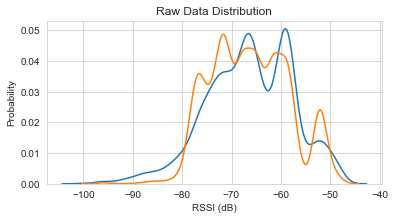

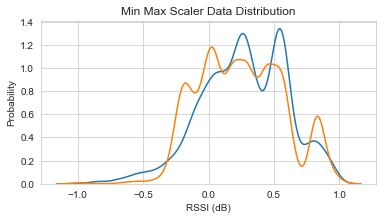

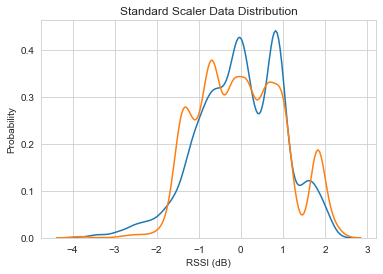

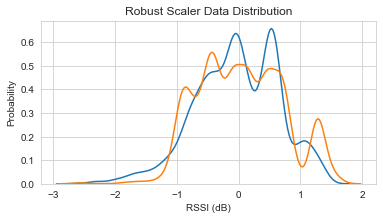

In [4]:
# Just for "debug" purposes we are plotting probability density function (PDF) based on kernel density estimation (KDE) for
# different types of data scaling (raw data, min max scaler between -1 and 1, standard scaler and robust scaler).
# For our data scaling doesn't seem to affect the overall shape of the distributions since they are already related 
# (the Rolling Mean RSSI is derived from the RSSI) and they probably have very similar ranges in the raw data.
# Notwidthstanding, check these examples which my motivation to conduct this little experiment:
# - https://www.kaggle.com/discdiver/guide-to-scaling-and-standardizing
# - https://towardsdatascience.com/scale-standardize-or-normalize-with-scikit-learn-6ccc7d176a02

# We set the plot size
plt.figure(figsize=(6,3))
# Title
plt.title('Raw Data Distribution')
# The KDE plot for the RSSI column
sns.kdeplot(data['rssi'], label='RSSI');
# The KDE plot for the Rolling Mean RSSI column
sns.kdeplot(data['rolling_mean_rssi'], label='Rolling Mean RSSI');
# The X Label
plt.xlabel('RSSI (dB)')
# The Y Label
plt.ylabel('Probability')
# Show the plot
plt.show()

# Now we do it all again but we scale the data with 'minmax_scale' (Min Max Scaler)
# NOTE: I used -1 and 1 as an example here because regression using SVR and some kernel (polynomial) got stuck if I used the
# default which is 0 and 1. It seems that SVM/SVR, and other algorithms, work better when that is centered around 0 thus -1, 1
# gets us close to that.
plt.figure(figsize=(6,3))
plt.title('Min Max Scaler Data Distribution')
# The KDE plot for the RSSI column after scaling it using the 'minmax_scale' to keep everything between -1 and 1.
sns.kdeplot(minmax_scale(data['rssi'], (-1,1)), label='RSSI')
# The KDE plot for the Rolling Mean RSSI column after scaling it using the 'minmax_scale' to keep everything between -1 and 1.
sns.kdeplot(minmax_scale(data['rolling_mean_rssi'], (-1,1)), label='Rolling Mean RSSI');
plt.xlabel('RSSI (dB)')
plt.ylabel('Probability')
plt.show()

# Now we do it all again but we scale the data with 'scale' (Standard Scaler)
plt.figure(figsize=(6,4))
plt.title('Standard Scaler Data Distribution')
# The KDE plot for the RSSI column after scaling it using the standard scaler
sns.kdeplot(scale(data['rssi']), label='RSSI')
# The KDE plot for the Rolling Mean RSSI column after scaling it using the standard scaler
sns.kdeplot(scale(data['rolling_mean_rssi']), label='Rolling Mean RSSI');
plt.xlabel('RSSI (dB)')
plt.ylabel('Probability')
plt.show()

# Now we do it all again but we scale the data with 'robust_scale' (Robust Scaler)
plt.figure(figsize=(6,3))
plt.title('Robust Scaler Data Distribution')
# The KDE plot for the RSSI column after scaling it using the robust scaler
sns.kdeplot(robust_scale(data['rssi']), label='RSSI')
# The KDE plot for the Rolling Mean RSSI column after scaling it using the robust scaler
sns.kdeplot(robust_scale(data['rolling_mean_rssi']), label='Rolling Mean RSSI');
plt.xlabel('RSSI (dB)')
plt.ylabel('Probability')
plt.show()

## Regression

### Prepare Data

In [5]:
# Number of splits for Cross Validation 
n_splits = 3
# Let's use a fixed random state in order to ensure reproducible results.
# But it may be a good idea to change this from time to time to make sure that we are not getting good results due to luck.
random_state = 656

# Initialize the 'data_plot' variable that will point to the whole data.
# Alternatively, we may want to discard outlies based on the zscore.
data_filtered = data #[data.rssi_zscore < 3]
y_labels_filtered = data_filtered['distance'].astype(str).values.reshape(-1,1)
data_plot, data_plot_test = train_test_split(data_filtered, shuffle=True, 
                                             stratify=y_labels_filtered, 
                                             test_size=0.3, random_state=random_state)
data_plot = data_plot.reset_index(drop=True)
data_plot_test = data_plot_test.reset_index(drop=True)

# The data filtered by device = 'laptop'
data_plot_laptop = data_plot[data_plot.device == 'laptop']
# The data filtered by device = 'smartphone'
data_plot_smartphone = data_plot[data_plot.device == 'smartphone']

# The data filtered by device = 'laptop'
data_plot_laptop_test = data_plot_test[data_plot_test.device == 'laptop']
# The data filtered by device = 'smartphone'
data_plot_smartphone_test = data_plot_test[data_plot_test.device == 'smartphone']

# Get and reshape the training data from the dataframe (we can use either 'rssi' or 'rolling_mean_rssi')
X = data_plot['rolling_mean_rssi'].values.reshape(-1,1)
# Get the corresponding weights that were previously computed in order to use them on Weightled Linear Regression,
# or on any other algorithm that supports weighting.
X_weight = data_plot['weight']

# Get the distance measurements that correspond to the training data.
y = data_plot['distance'].values.reshape(-1,1)
# Also convert the measurements to string labels since Stratified Cross Validation does not work properly with floats.
y_labels = data_plot['distance'].astype(str).values.reshape(-1,1)

# Get and reshape the testing data from the dataframe (we can use either 'rssi' or 'rolling_mean_rssi')
X_test = data_plot_test['rolling_mean_rssi'].values.reshape(-1,1)
# Get the corresponding weights that were previously computed in order to use them on Weightled Linear Regression,
# or on any other algorithm that supports weighting.
X_weight_test = data_plot_test['weight']

# Get the distance measurements that correspond to the testing data.
y_test = data_plot_test['distance'].values.reshape(-1,1)
# Also convert the measurements to string labels since Stratified Cross Validation does not work properly with floats.
y_labels_test = data_plot_test['distance'].astype(str).values.reshape(-1,1)

# Get and reshape the training data from the dataframe for the laptop device (we can use either 'rssi' or 'rolling_mean_rssi')
X_laptop = data_plot_laptop['rolling_mean_rssi'].values.reshape(-1,1)
# Get the distance measurements that correspond to the laptop training data.
y_laptop = data_plot_laptop['distance'].values.reshape(-1,1)

# Get and reshape the training data from the dataframe for the smartphone device (we can use either 'rssi' or 'rolling_mean_rssi')
X_smartphone = data_plot_smartphone['rolling_mean_rssi'].values.reshape(-1,1)
# Get the distance measurements that correspond to the smartphone training data.
y_smartphone = data_plot_smartphone['distance'].values.reshape(-1,1)

# Get and reshape the testing data from the dataframe for the smartphone device (we can use either 'rssi' or 'rolling_mean_rssi')
X_smartphone_test = data_plot_smartphone_test['rolling_mean_rssi'].values.reshape(-1,1)
# Get the distance measurements that correspond to the smartphone testing data.
y_smartphone_test = data_plot_smartphone_test['distance'].values.reshape(-1,1)

# Get and reshape the testing data from the dataframe for the laptop device (we can use either 'rssi' or 'rolling_mean_rssi')
X_laptop_test = data_plot_laptop_test['rolling_mean_rssi'].values.reshape(-1,1)
# Get the distance measurements that correspond to the laptop testing data.
y_laptop_test = data_plot_laptop_test['distance'].values.reshape(-1,1)

# Get the distance, rssi and rolling_mean_rssi means for each "device and distance" pair.
# For the laptop:
data_plot_laptop_means = data_plot_laptop.groupby(['device','distance'])[['distance','rssi','rolling_mean_rssi']].mean()
# But also for the laptop:
data_plot_smartphone_means = data_plot_smartphone.groupby(['device','distance'])[['distance','rssi','rolling_mean_rssi']].mean()

# The scorers to be computed as part of the grid search cross validation. The ones below are all the ones that are relevant
# when dealing with regression problems.
scorers = {'explained_variance_score': make_scorer(explained_variance_score),
           'max_error': make_scorer(max_error),
           'mean_absolute_error': make_scorer(mean_absolute_error),
           'mean_squared_error': make_scorer(mean_squared_error),
           'r2_score': make_scorer(r2_score)}
# Despite computing a BUNCH of scorers just so I can inspect them later, only one can be selected as the indicator to be used
# when deciding which parameters are better. Since we are currently dealing with regression, the R2 scorer is a common choice.
refit_scorer = 'r2_score'
# Polynomial Degree for Linear Regression
poly_degree=1

### Linear Regression

In [6]:
# Prepare a pipeline for linear regression
linear_regression_pipeline = Pipeline([
    # First step: a scaler
    # TODO: I'm still not sure which is the best scaler to use.
    ('scaler', StandardScaler()),
    # Just so than we can try to use polynomial degrees other than 1.
    ('poly', PolynomialFeatures(degree=poly_degree)),
    # Second step: the regression algorithm
    ('regression', LinearRegression())
])
# A dictionary of parameters to permutate and test using GridSearchCV
linear_regression_parameters = {}
# Create the GridSearchCV for the pipeline and parameters above, using a StratifiedKFold approach with 'n_splits' that are 
# shuffled according to the 'random_state' define above. This should should ensure that each split is balanced in terms 
# of data for each recorded distance.
# Also note the GridSearchCV is being run with the previous defined scorers and refit scorer, n_jobs=-1 to launch as many
# processes as CPU Cores/Threads are available, and verbose=1 # to get some feedback as the parameter search is running.
linear_regression_grid = GridSearchCV(linear_regression_pipeline, linear_regression_parameters,
                                      cv=StratifiedKFold(n_splits=n_splits,
                                                         shuffle=True,
                                                         random_state=random_state).split(X, y_labels),
                                      scoring=scorers, refit=refit_scorer, n_jobs=-1, verbose=1)
# Fit the GridSearchCV
linear_regression_grid.fit(X, y);
# Save the best estimator found for possible use in the future.
# TODO: One of the possible uses is detecting that the file is already present and skip all the training and cross validation
# to speed things up.
joblib.dump(linear_regression_grid.best_estimator_ , 'out/linear_regression_grid.joblib')

Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    2.6s finished


['out/linear_regression_grid.joblib']

### Weighted Linear Regression

In [7]:
# Prepare a pipeline for weighted linear regression
weighted_linear_regression_pipeline = Pipeline([
    # First step: a scaler
    # TODO: I'm still not sure which is the best scaler to use.
    ('scaler', StandardScaler()),
    # Second step: the regression algorithm
    ('regression', LinearRegression())
])
# A dictionary of parameters to permutate and test using GridSearchCV
weighted_linear_regression_parameters = {}
# Create the GridSearchCV for the pipeline and parameters above, using a StratifiedKFold approach with 'n_splits' that are 
# shuffled according to the 'random_state' define above. This should should ensure that each split is balanced in terms 
# of data for each recorded distance.
# Also note the GridSearchCV is being run with the previous defined scorers and refit scorer, n_jobs=-1 to launch as many
# processes as CPU Cores/Threads are available, and verbose=1 # to get some feedback as the parameter search is running.
weighted_linear_regression_grid = GridSearchCV(weighted_linear_regression_pipeline, weighted_linear_regression_parameters,
                                               cv=StratifiedKFold(n_splits=n_splits,
                                                                  shuffle=True,
                                                                  random_state=random_state).split(X, y_labels),
                                               scoring=scorers, refit=refit_scorer, n_jobs=-1, verbose=1)
# Fit the GridSearchCV
weighted_linear_regression_grid.fit(X, y, regression__sample_weight=X_weight)
# Save the best estimator found for possible use in the future.
# TODO: One of the possible uses is detecting that the file is already present and skip all the training and cross validation
# to speed things up.
joblib.dump(weighted_linear_regression_grid.best_estimator_ , 'out/weighted_linear_regression_grid.joblib')

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    2.0s finished


['out/weighted_linear_regression_grid.joblib']

### SVR (Support-vector Machine Regression)

In [8]:
# Prepare a pipeline for SVR
svr_pipeline = Pipeline([
    # First step: a scaler
    # TODO: I'm still not sure which is the best scaler to use.
    ('scaler', StandardScaler()),
    # Second step: the regression algorithm
    # gamma is set to scale as this will be the new sklearn default going forward and I feel that the current default value 
    # doesn't make much sense when working with unidimensional data. More details: 
    # https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVR.html
    ('regression', SVR(gamma='scale'))
])
# A dictionary of parameters to permutate and test using GridSearchCV
# For details regarding the paramets see: https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVR.html
svr_parameters = {
    'regression__kernel': [
        #'linear',
        #'poly',
        'rbf', #Default
        #'sigmoid'
    ],
    'regression__gamma': [
        #'auto', #Default
        'scale'
    ],
    'regression__C': [
        0.1, 0.125, 0.25, 0.5, 
        1.0, #Default
        2.0, 4.0, 8.0, 10.0
    ],
    'regression__epsilon': [
        0.01, 0.0125, 0.025, 0.05,
        0.1, #Default
        0.2, 0.4, 0.8, 1.0
    ]
}
# Create the GridSearchCV for the pipeline and parameters above, using a StratifiedKFold approach with 'n_splits' that are 
# shuffled according to the 'random_state' define above. This should should ensure that each split is balanced in terms 
# of data for each recorded distance.
# Also note the GridSearchCV is being run with the previous defined scorers and refit scorer, n_jobs=-1 to launch as many
# processes as CPU Cores/Threads are available, and verbose=1 # to get some feedback as the parameter search is running.
svr_grid = GridSearchCV(svr_pipeline, svr_parameters,
                        cv=StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=random_state).split(X, y_labels),
                        scoring=scorers, refit=refit_scorer, n_jobs=-1, verbose=1)
# Fit the GridSearchCV
svr_grid.fit(X, y.ravel())
# Print the best parameters found by GridSearchCV
print('SVR Grid Search:', svr_grid.best_params_)
# Save the best estimator found for possible use in the future.
# TODO: One of the possible uses is detecting that the file is already present and skip all the training and cross validation
# to speed things up.
joblib.dump(svr_grid.best_estimator_, 'out/svr_grid.joblib')

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 3 folds for each of 81 candidates, totalling 243 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    6.8s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   31.4s
[Parallel(n_jobs=-1)]: Done 243 out of 243 | elapsed:   40.3s finished


SVR Grid Search: {'regression__C': 1.0, 'regression__epsilon': 0.4, 'regression__gamma': 'scale', 'regression__kernel': 'rbf'}


['out/svr_grid.joblib']

### NuSVR  (Support-vector Machine Regression)

In [9]:
nusvr_pipeline = Pipeline([
    # First step: a scaler
    # TODO: I'm still not sure which is the best scaler to use.
    ('scaler', StandardScaler()),
    # Second step: the regression algorithm
    # gamma is set to scale as this will be the new sklearn default going forward and I feel that the current default value 
    # doesn't make much sense when working with unidimensional data. More details: 
    # https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVR.html
    ('regression', NuSVR(gamma='scale'))
])
# A dictionary of parameters to permutate and test using GridSearchCV
# For details regarding the paramets see: https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVR.html
nusvr_parameters = {
    'regression__kernel': [
        #'linear',
        #'poly',
        'rbf', #Default
        #'sigmoid'
    ],
    'regression__nu': [
        0.01, 0.1, 0.25,
        0.5, #Default
        0.75, 0.99, 1.0
    ],
    'regression__C': [
        0.1, 0.125, 0.25, 0.5, 
        1.0, #Default
        2.0, 4.0, 8.0, 10.0
    ],
}
# Create the GridSearchCV for the pipeline and parameters above, using a StratifiedKFold approach with 'n_splits' that are 
# shuffled according to the 'random_state' define above. This should should ensure that each split is balanced in terms 
# of data for each recorded distance.
# Also note the GridSearchCV is being run with the previous defined scorers and refit scorer, n_jobs=-1 to launch as many
# processes as CPU Cores/Threads are available, and verbose=1 # to get some feedback as the parameter search is running.
nusvr_grid = GridSearchCV(nusvr_pipeline, nusvr_parameters,
                          cv=StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=random_state).split(X, y_labels),
                          scoring=scorers, refit=refit_scorer, n_jobs=-1, verbose=1)
# Fit the GridSearchCV
nusvr_grid.fit(X, y.ravel())
# Print the best parameters found by GridSearchCV
print('NuSVR Grid Search:', nusvr_grid.best_params_)
# Save the best estimator found for possible use in the future.
# TODO: One of the possible uses is detecting that the file is already present and skip all the training and cross validation
# to speed things up.
joblib.dump(nusvr_grid.best_estimator_ , 'out/nusvr_grid.joblib')

Fitting 3 folds for each of 63 candidates, totalling 189 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  51 tasks      | elapsed:    6.5s
[Parallel(n_jobs=-1)]: Done 189 out of 189 | elapsed:   33.1s finished


NuSVR Grid Search: {'regression__C': 1.0, 'regression__kernel': 'rbf', 'regression__nu': 0.75}


['out/nusvr_grid.joblib']

### KNN Regression (K-Nearest Neighbors Regression)

In [10]:
knnr_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('regression', KNeighborsRegressor())
])

knnr_parameters = {
    'regression__n_neighbors': list(range(1,300)),
    'regression__weights': ['uniform', 'distance']
}

knnr_grid = GridSearchCV(knnr_pipeline, knnr_parameters,
                          cv=StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=random_state).split(X, y_labels),
                          scoring=scorers, refit=refit_scorer, n_jobs=-1, verbose=1)

knnr_grid.fit(X, y.ravel())
print('KNN Regression Grid Search:', knnr_grid.best_params_)

joblib.dump(knnr_grid.best_estimator_ , 'out/knnr_grid.joblib')

Fitting 3 folds for each of 598 candidates, totalling 1794 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 656 tasks      | elapsed:    5.7s
[Parallel(n_jobs=-1)]: Done 1656 tasks      | elapsed:   25.6s
[Parallel(n_jobs=-1)]: Done 1779 out of 1794 | elapsed:   28.8s remaining:    0.1s


KNN Regression Grid Search: {'regression__n_neighbors': 139, 'regression__weights': 'uniform'}


[Parallel(n_jobs=-1)]: Done 1794 out of 1794 | elapsed:   29.1s finished


['out/knnr_grid.joblib']

### Predictions

In [11]:
# Prepare 1000 data points spaced evengly between the minimum and maximum RSSI values that were recorded during training.
# This will just be used to plot the regression lines/curves.
X_ = np.linspace(data['rssi'].min(), data['rssi'].max(), 1000).reshape(-1,1)

# Predict the distance for the generate data points using each of the previous trained models.
# Linear Regression
linear_regression_predictions = linear_regression_grid.predict(X_)
# Weighted Linear Regregission
weighted_linear_regression_predictions = weighted_linear_regression_grid.predict(X_)
# SVR
svr_predictions = svr_grid.predict(X_)
# NuSVR
nusvr_predictions = nusvr_grid.predict(X_)
# KNN Regression
knnr_predictions = knnr_grid.predict(X_)

#### Plots

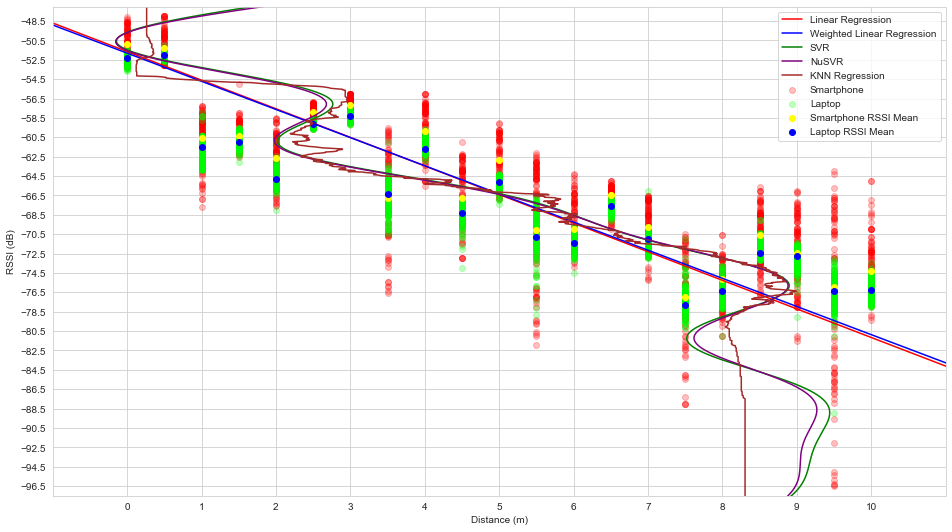

In [12]:
# Now let's plot the results
# Define the plot size
plt.figure(figsize=(16,9))

# The scatter plot for the data collected for the smartphone in transparent red
plt.scatter(y_smartphone, X_smartphone, c='#ff00003f', label='Smartphone')
# The scatter plot the data collected for the laptop transparent green
plt.scatter(y_laptop, X_laptop,c='#00ff003f', label='Laptop')

# Plot the points that mark the mean RSSI recorded by the smartphone for a given distance (yellow).
plt.scatter(data_plot_smartphone_means.distance,
            data_plot_smartphone_means.rssi,
            c='yellow', label='Smartphone RSSI Mean')
# Plot the points that mark the mean RSSI recorded by the laptop for a given distance (blue).
plt.scatter(data_plot_laptop_means.distance,
            data_plot_laptop_means.rssi,
            c='blue', label='Laptop RSSI Mean')

# Plot the prediction line for linear regression in red
plt.plot(linear_regression_predictions, X_, color='red', label='Linear Regression')
# Plot the prediction line for weighted linear regression in blue
plt.plot(weighted_linear_regression_predictions, X_, color='blue',label='Weighted Linear Regression')
# Plot the prediction curve for SVR in green
plt.plot(svr_predictions, X_, color='green', label='SVR')
# Plot the prediction curve for NuSVR in purple
plt.plot(nusvr_predictions, X_, color='purple', label='NuSVR')
# Plot the prediction curve for KNN Regression in brown
plt.plot(knnr_predictions, X_, color='brown', label='KNN Regression')

# Set the X axis between the disance minimum -1 and the distance maximum +1 
plt.xlim(y.min()-1, y.max()+1)
# Set the Y axis between the RSSI minimum -1 and the RSSI maximum +1 
plt.ylim(X.min()-1, X.max()+1)

# Set the X axis ticks between the distance minimum -1 and the distance maximum +1 
plt.xticks(np.arange(y.min(), y.max()+1, 1.0))
# Set the Y axis ticks between the RSSI minimum -1 and the RSSI maximum +1 
plt.yticks(np.arange(X.min(), X.max()+1, 2.0))

# Set the X axis label
plt.xlabel('Distance (m)')
# Set the Y axis label
plt.ylabel('RSSI (dB)')

# Enable the grid
plt.grid(True)
# Show and place the legent
plt.legend(loc='upper right');

# Show the plot
plt.show()

### Cross Validated Predictions

In [13]:
# Now let's thake the best estimator that was found with GridSearchCV for each algorithm and put them to the test.
# These estimators should already be parametrized with the best parameters and we will retrain using cross validation
# just like before and perform predictions on the data that is kept for testing on each fold. We store the predicted
# distances and then store the difference to the real ones on a dedicate column in order to compute summarize statistics.

# Linear Regression
data_plot_test['linear_regression_results'] = cross_val_predict(linear_regression_grid.best_estimator_, X_test, y_test,
                                                                # The split is the same we used previously for GridSearchCV 
                                                                cv=StratifiedKFold(n_splits=n_splits, shuffle=True,
                                                                                   random_state=random_state).split(X_test, y_labels_test))
data_plot_test['linear_regression_error'] = np.abs(data_plot_test['linear_regression_results'] - data_plot_test['distance'])

# Weighted Linear Regression
data_plot_test['weighted_linear_regression_results'] = cross_val_predict(weighted_linear_regression_grid.best_estimator_, X_test, y_test,
                                                                        # The split is the same we used previously for GridSearchCV 
                                                                        cv=StratifiedKFold(n_splits=n_splits, shuffle=True,
                                                                                           random_state=random_state).split(X_test, y_labels_test),
                                                                                           fit_params = { 'regression__sample_weight': X_weight_test })
data_plot_test['weighted_linear_regression_error'] = np.abs(data_plot_test['weighted_linear_regression_results'] - data_plot_test['distance'])

# SVR
data_plot_test['svr_results'] = cross_val_predict(svr_grid.best_estimator_, X_test, y_test.ravel(),
                                                  cv=StratifiedKFold(n_splits=n_splits,
                                                  shuffle=True, random_state=random_state).split(X_test, y_labels_test))
data_plot_test['svr_error'] = np.abs(data_plot_test['svr_results'] - data_plot_test['distance'])

# NuSVR
data_plot_test['nusvr_results'] = cross_val_predict(nusvr_grid.best_estimator_, X_test, y_test.ravel(),
                                                    cv=StratifiedKFold(n_splits=n_splits,
                                                    shuffle=True, random_state=random_state).split(X_test, y_labels_test))
data_plot_test['nusvr_error'] = np.abs(data_plot_test['nusvr_results'] - data_plot_test['distance'])

# KNN Regression
data_plot_test['knnr_results'] = cross_val_predict(knnr_grid.best_estimator_, X_test, y_test.ravel(),
                                                  cv=StratifiedKFold(n_splits=n_splits,
                                                  shuffle=True, random_state=random_state).split(X_test, y_labels_test))
data_plot_test['knnr_error'] = np.abs(data_plot_test['knnr_results'] - data_plot_test['distance'])

# The error percentiles we are interested in
error_percentiles = [0.25, 0.5, 0.75, 0.9, 0.95, 0.99]
# Show the distance error indicators
data_plot_test[['linear_regression_error',
                'weighted_linear_regression_error',
                'svr_error',
                'nusvr_error',
                'knnr_error']].describe(error_percentiles)

,linear_regression_error,weighted_linear_regression_error,svr_error,nusvr_error,knnr_error
count,2441.000000,2441.000000,2441.000000,2441.000000,2441.000000
mean,1.180451,1.180844,1.083565,1.089369,1.064256
std,0.892498,0.893152,0.803559,0.799165,0.798922
min,0.000203,0.001954,0.000205,0.000610,0.000000
25%,0.474677,0.480601,0.472351,0.537044,0.381295
50%,1.035639,1.037650,0.981893,0.957437,0.964029
75%,1.680271,1.664868,1.459003,1.466280,1.438849
90%,2.374523,2.374785,2.050489,2.056789,2.057554
95%,2.763911,2.795694,2.558510,2.557447,2.561151
99%,4.052874,4.029083,3.738419,3.719090,3.781295


## Raw Data Visualization

### "General" Boxplot

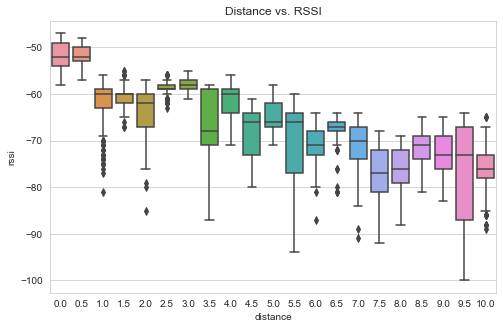

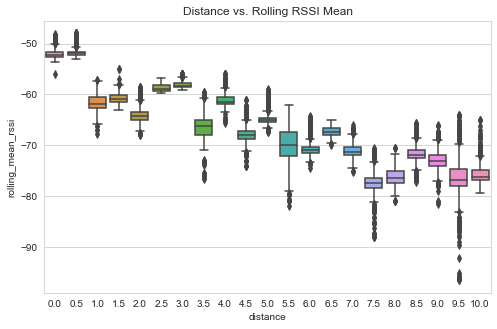

In [14]:
# Understanding Boxplots: https://towardsdatascience.com/understanding-boxplots-5e2df7bcbd51

# Using Seaborn Boxplot to get an overview of the whole distance vs. RSSI correlation.
# NOTE: I could have possibly made this with plain Matplotlib but Seaborn makes it prettier and easier.
# Set the figure size
plt.figure(figsize=(8,5))
# Set the title
plt.title('Distance vs. RSSI')
# Boxplot
sns.boxplot(x=data['distance'], y=data['rssi'])
# Show the plot
plt.show()

# Using Seaborn Boxplot to get an overview of the whole distance vs. rolling mean RSSI correlation.
# NOTE: I could have possibly made this with plain Matplotlib but Seaborn makes it prettier and easier.
# Set the figure size
plt.figure(figsize=(8,5))
# Set the title
plt.title('Distance vs. Rolling RSSI Mean')
# Boxplot
sns.boxplot(x=data['distance'], y=data['rolling_mean_rssi'])
# Show the plot
plt.show()

### RSSI over time per distance and device

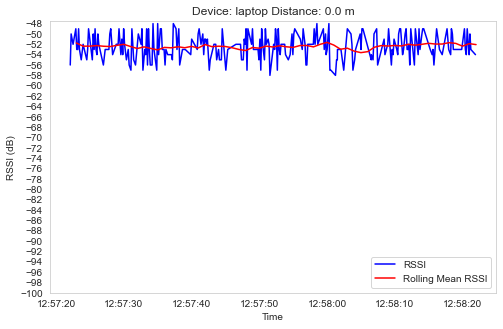

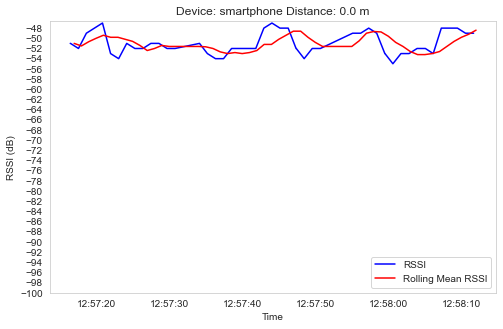

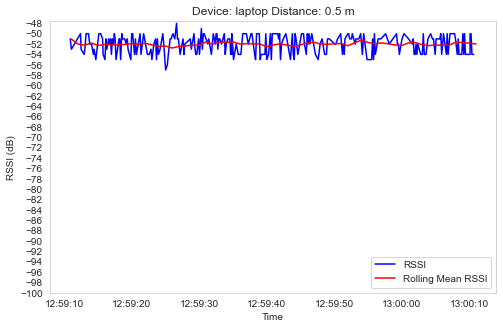

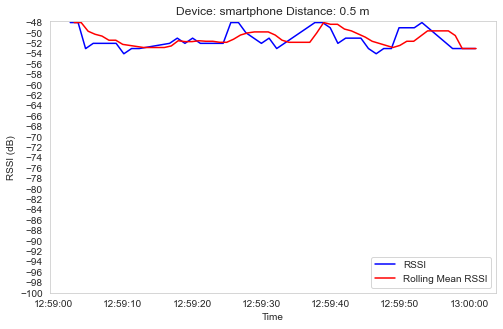

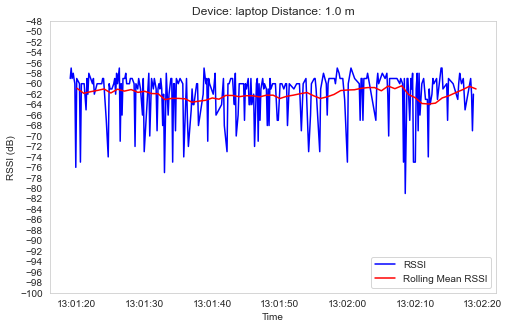

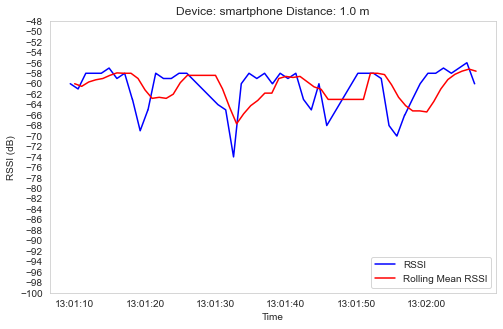

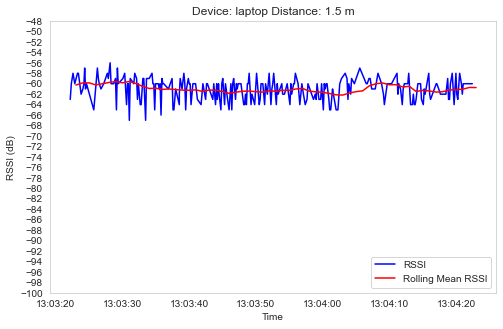

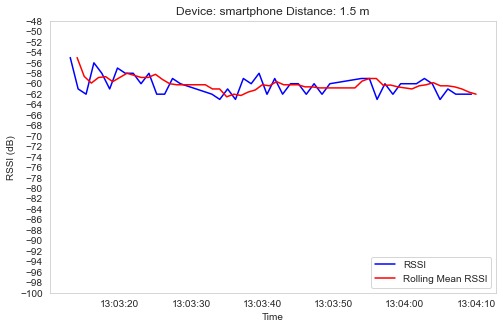

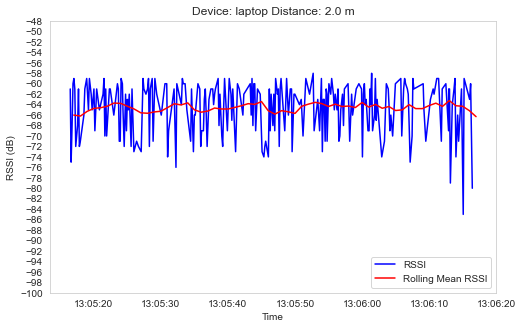

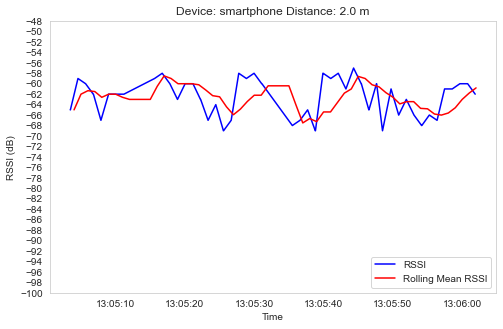

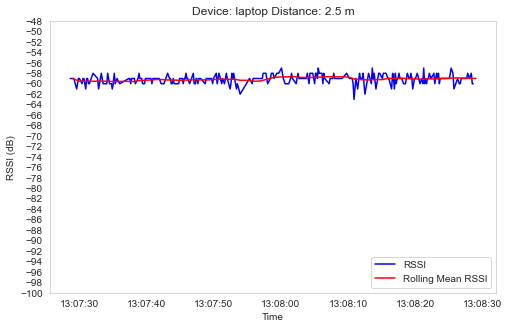

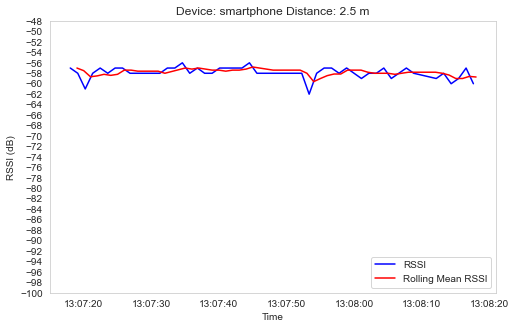

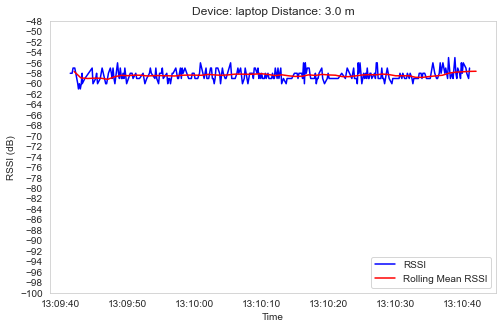

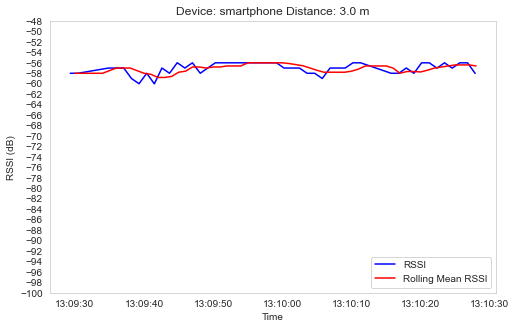

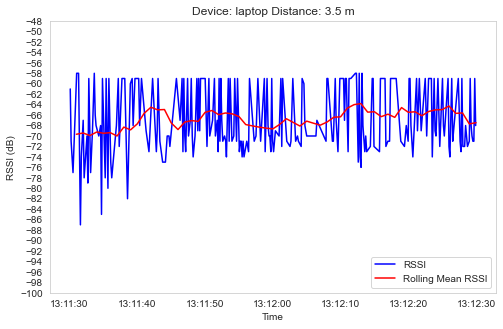

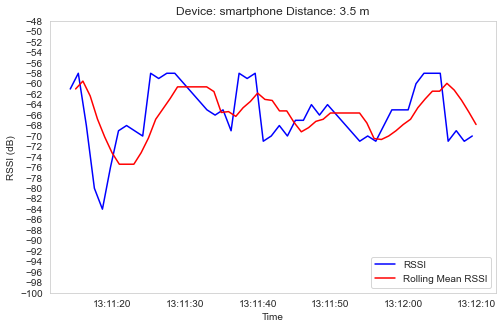

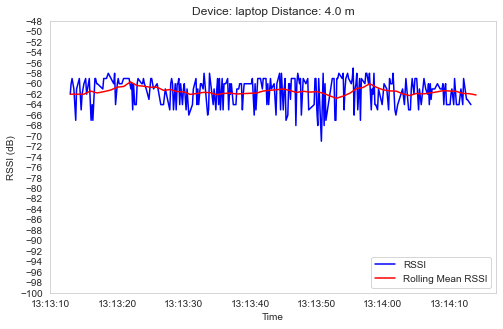

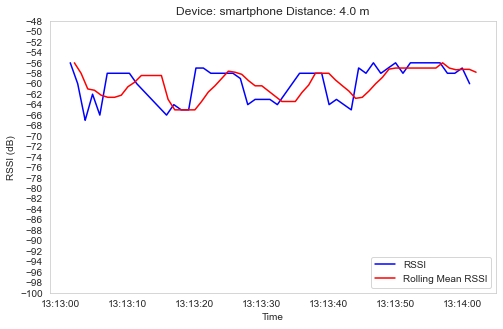

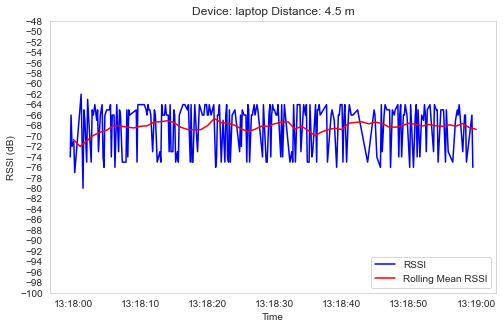

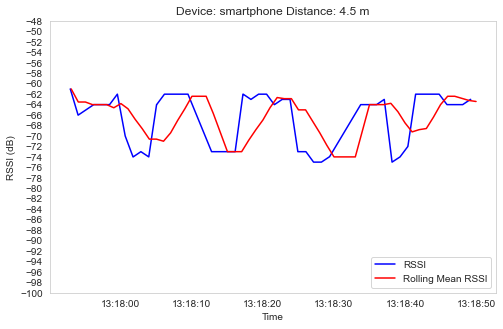

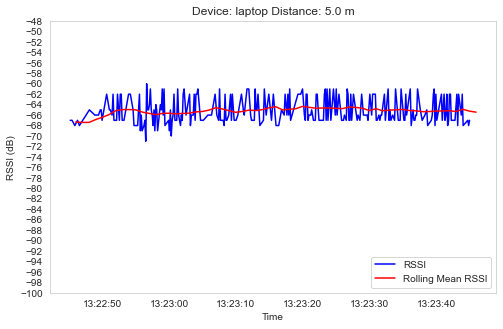

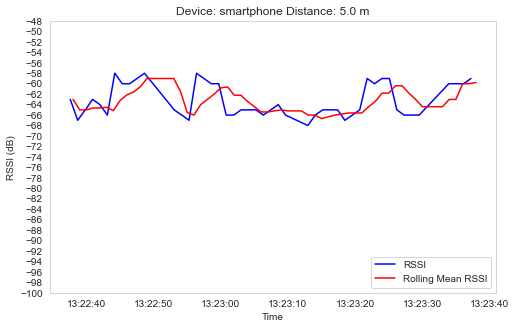

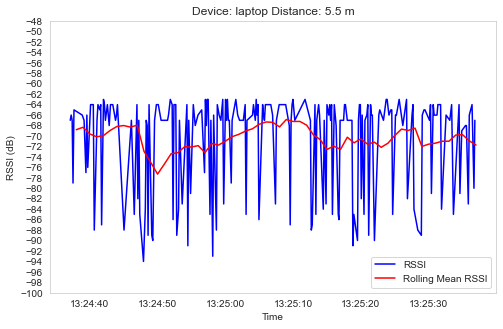

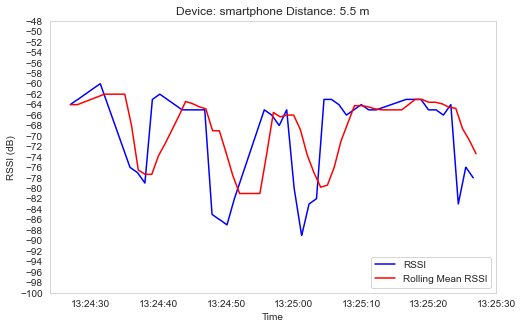

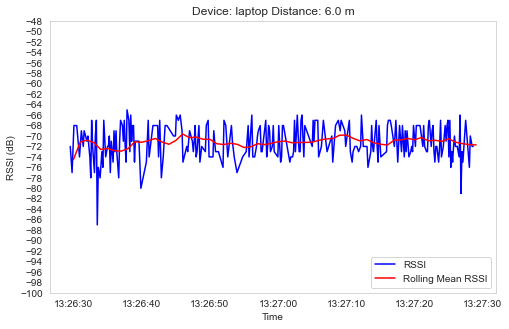

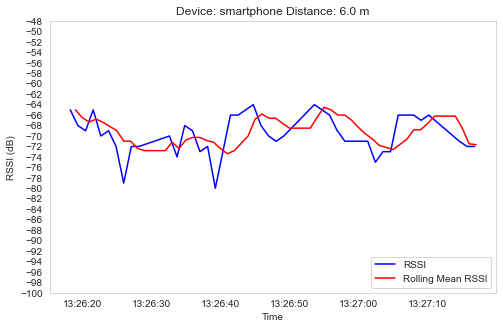

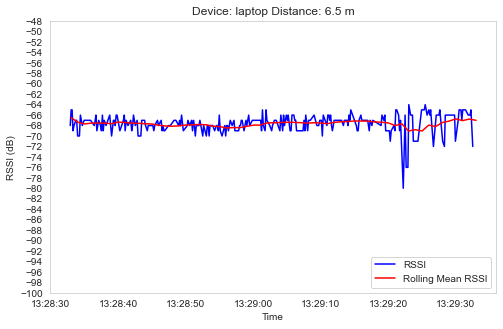

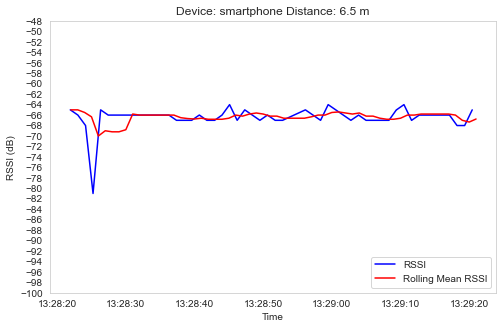

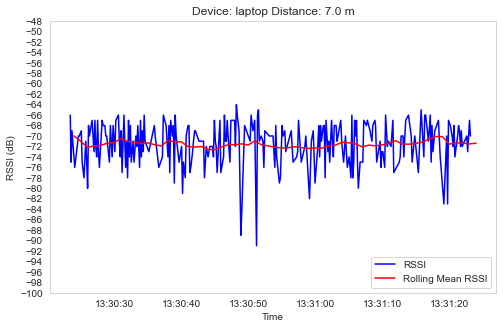

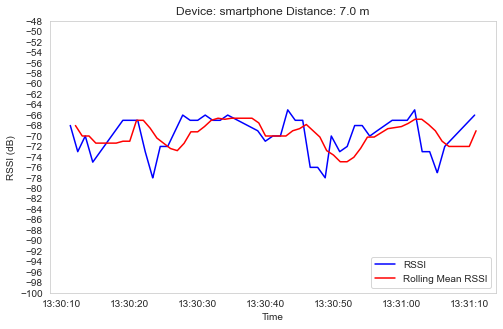

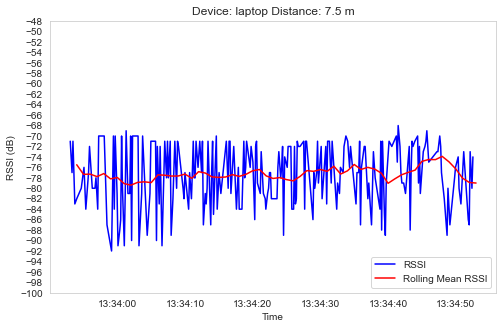

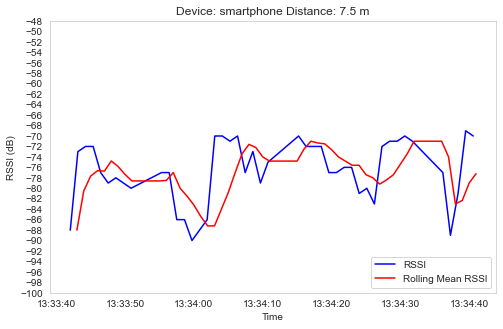

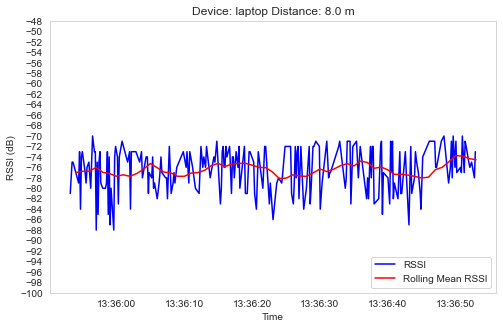

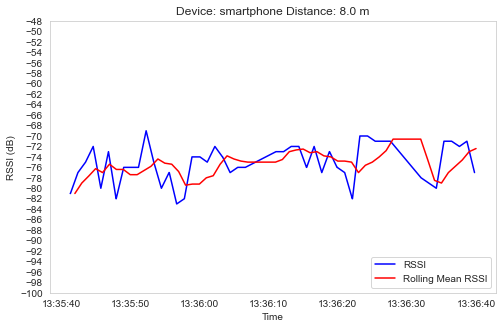

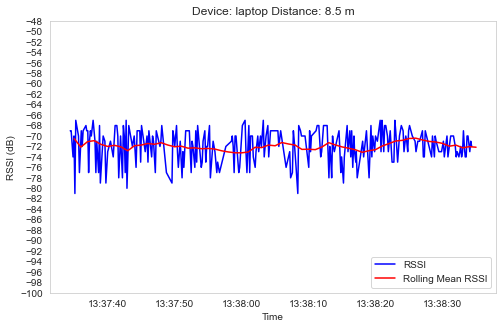

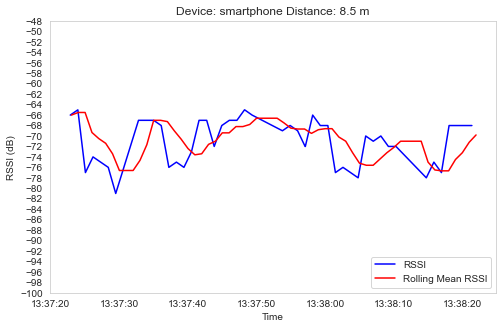

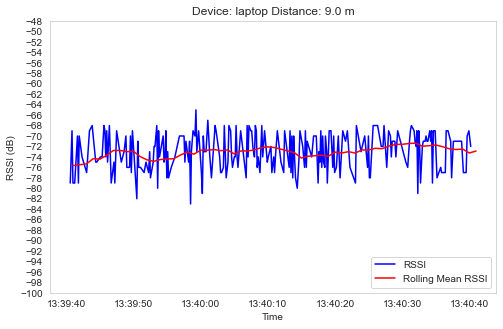

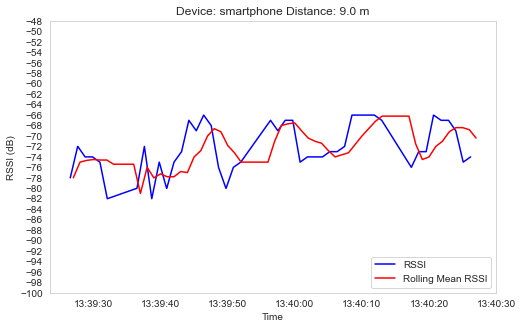

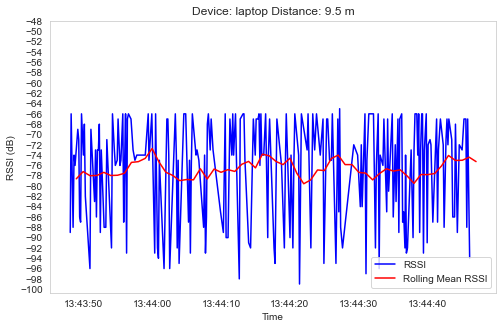

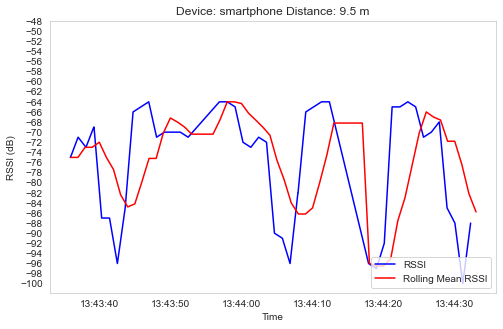

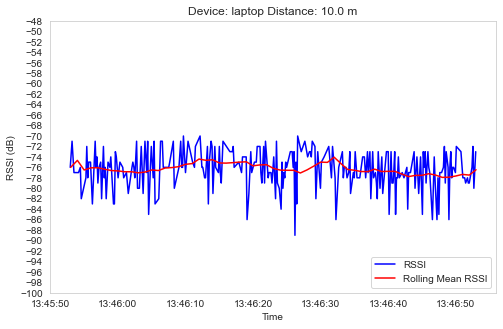

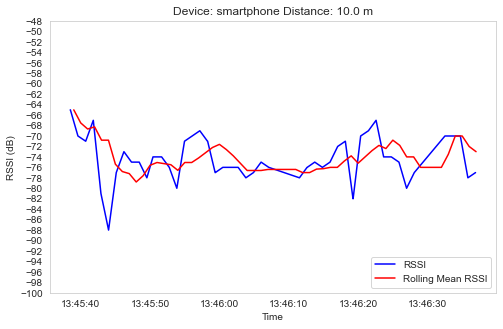

In [15]:
# Minimum RSSI recorded
min_rssi = data['rssi'].min()
# Maximum RSSI recorded
max_rssi = data['rssi'].max()

# Iterate over each distance/device pair to plot a line chart of RSSI and Rolling Mean RSSI variation over the time it
# took to collect data at each distance and device.
for k, d in data.groupby(['distance','device']):
    # Resample data 1000ms interval between samples in order to mask avoid any gaps that exist in the recorded data.
    dr = resample_group(d, 1000)
    # Set the plot size
    plt.figure(figsize=(8, 5))
    # Set the plot title
    plt.title('Device: '+k[1]+' Distance: '+str(k[0])+' m')
    # Set the X axis label
    plt.xlabel('Time')
    # Set the Y axis label
    plt.ylabel('RSSI (dB)')
    # Plot the RSSI values over time in blue
    plt.plot(d['timestamp'], d['rssi'], label='RSSI', color='blue')
    # Plot the Rolling Mean RSSI values over time in red
    plt.plot(dr.index, dr['rolling_mean_rssi'], label='Rolling Mean RSSI', color='red')
    # Set the Y axis ticks based on minimum and maximum RSSI
    plt.yticks(np.arange(min_rssi, max_rssi, 2.0))
    # Show legend and set its location
    plt.legend(loc='lower right');
    # Show a grid
    plt.grid()
    # Show the plot
    plt.show()

## What if we use RSSI and Rolling Mean RSSI at the same time?
This is probably no the best idea ever, since RSSI and Rolling Mean RSSI are tightly connected and they are not really two different features. The second is just a filtered version of the second. However, I just wanted to try out a scenario in which we have more than a single feature and to try out 3D data visualization. Ideally, we should eventually combine Rolling Mean RSSI with other sensor data, such as accelerometer or gyroscope data but it shouldn't be too hard to adapt the code below.

### Prepare Data

In [16]:
# We will mostly use the same data that we prepared for the 2D data case.
# However, some variables need to be redefined.
# X is now composed of both RSSI and Rolling Mean RSSI
X = data_plot[['rssi','rolling_mean_rssi']].values
# X_laptop is also now composed of both RSSI and Rolling Mean RSSI
X_laptop = data_plot_laptop[['rssi','rolling_mean_rssi']].values
# X_smartphone is also now composed of both RSSI and Rolling Mean RSSI
X_smartphone = data_plot_smartphone[['rssi','rolling_mean_rssi']].values

# X_test is now composed of both RSSI and Rolling Mean RSSI
X_test = data_plot_test[['rssi','rolling_mean_rssi']].values
# X_laptop_test is also now composed of both RSSI and Rolling Mean RSSI
X_laptop_test = data_plot_laptop_test[['rssi','rolling_mean_rssi']].values
# X_smartphone_test is also now composed of both RSSI and Rolling Mean RSSI
X_smartphone_test = data_plot_smartphone_test[['rssi','rolling_mean_rssi']].values

### Linear Regression

In [17]:
# Prepare a pipeline for linear regression
linear_regression_pipeline = Pipeline([
    # First step: a scaler
    # TODO: I'm still not sure which is the best scaler to use.
    ('scaler', StandardScaler()),
    # Second step: the regression algorithm
    ('regression', LinearRegression())
])
# A dictionary of parameters to permutate and test using GridSearchCV
linear_regression_parameters = {}
# Create the GridSearchCV for the pipeline and parameters above, using a StratifiedKFold approach with 'n_splits' that are 
# shuffled according to the 'random_state' define above. This should should ensure that each split is balanced in terms 
# of data for each recorded distance.
# Also note the GridSearchCV is being run with the previous defined scorers and refit scorer, n_jobs=-1 to launch as many
# processes as CPU Cores/Threads are available, and verbose=1 # to get some feedback as the parameter search is running.
linear_regression_grid = GridSearchCV(linear_regression_pipeline, linear_regression_parameters,
                                      cv=StratifiedKFold(n_splits=n_splits,
                                                         shuffle=True,
                                                         random_state=random_state).split(X, y_labels),
                                      scoring=scorers, refit=refit_scorer, n_jobs=-1, verbose=1)
# Fit the GridSearchCV
linear_regression_grid.fit(X, y);
# Save the best estimator found for possible use in the future.
# TODO: One of the possible uses is detecting that the file is already present and skip all the training and cross validation
# to speed things up.
joblib.dump(linear_regression_grid.best_estimator_ , 'out/linear_regression_grid_3d.joblib')

Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.0s finished


['out/linear_regression_grid_3d.joblib']

### Weighted Linear Regression

In [18]:
# Prepare a pipeline for weighted linear regression
weighted_linear_regression_pipeline = Pipeline([
    # First step: a scaler
    # TODO: I'm still not sure which is the best scaler to use.
    ('scaler', StandardScaler()),
    # Second step: the regression algorithm
    ('regression', LinearRegression())
])
# A dictionary of parameters to permutate and test using GridSearchCV
weighted_linear_regression_parameters = {}
# Create the GridSearchCV for the pipeline and parameters above, using a StratifiedKFold approach with 'n_splits' that are 
# shuffled according to the 'random_state' define above. This should should ensure that each split is balanced in terms 
# of data for each recorded distance.
# Also note the GridSearchCV is being run with the previous defined scorers and refit scorer, n_jobs=-1 to launch as many
# processes as CPU Cores/Threads are available, and verbose=1 # to get some feedback as the parameter search is running.
weighted_linear_regression_grid = GridSearchCV(weighted_linear_regression_pipeline, weighted_linear_regression_parameters,
                                               cv=StratifiedKFold(n_splits=n_splits,
                                                                  shuffle=True,
                                                                  random_state=random_state).split(X, y_labels),
                                               scoring=scorers, refit=refit_scorer, n_jobs=-1, verbose=1)
# Fit the GridSearchCV
weighted_linear_regression_grid.fit(X, y, regression__sample_weight=X_weight)
# Save the best estimator found for possible use in the future.
# TODO: One of the possible uses is detecting that the file is already present and skip all the training and cross validation
# to speed things up.
joblib.dump(weighted_linear_regression_grid.best_estimator_ , 'out/weighted_linear_regression_grid_3d.joblib')

Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.3s finished


['out/weighted_linear_regression_grid_3d.joblib']

### SVR (Support-vector Machine Regression)

In [19]:
# Prepare a pipeline for SVR
svr_pipeline = Pipeline([
    # First step: a scaler
    # TODO: I'm still not sure which is the best scaler to use.
    ('scaler', StandardScaler()),
    # Second step: the regression algorithm
    # gamma is set to scale as this will be the new sklearn default going forward and I feel that the current default value 
    # doesn't make much sense when working with unidimensional data. More details: 
    # https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVR.html
    ('regression', SVR(gamma='scale'))
])
# A dictionary of parameters to permutate and test using GridSearchCV
# For details regarding the paramets see: https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVR.html
svr_parameters = {
    'regression__kernel': [
        #'linear',
        #'poly',
        'rbf', #Default
        #'sigmoid'
    ],
    'regression__gamma': [
        #'auto', #Default
        'scale'
    ],
    'regression__C': [
        0.1, 0.125, 0.25, 0.5, 
        1.0, #Default
        2.0, 4.0, 8.0, 10.0
    ],
    'regression__epsilon': [
        0.01, 0.0125, 0.025, 0.05,
        0.1, #Default
        0.2, 0.4, 0.8, 1.0
    ]
}
# Create the GridSearchCV for the pipeline and parameters above, using a StratifiedKFold approach with 'n_splits' that are 
# shuffled according to the 'random_state' define above. This should should ensure that each split is balanced in terms 
# of data for each recorded distance.
# Also note the GridSearchCV is being run with the previous defined scorers and refit scorer, n_jobs=-1 to launch as many
# processes as CPU Cores/Threads are available, and verbose=1 # to get some feedback as the parameter search is running.
svr_grid = GridSearchCV(svr_pipeline, svr_parameters,
                        cv=StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=random_state).split(X, y_labels),
                        scoring=scorers, refit=refit_scorer, n_jobs=-1, verbose=1)
# Fit the GridSearchCV
svr_grid.fit(X, y.ravel())
# Print the best parameters found by GridSearchCV
print('SVR Grid Search:', svr_grid.best_params_)
# Save the best estimator found for possible use in the future.
# TODO: One of the possible uses is detecting that the file is already present and skip all the training and cross validation
# to speed things up.
joblib.dump(svr_grid.best_estimator_, 'out/svr_grid_3d.joblib')

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 3 folds for each of 81 candidates, totalling 243 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    5.7s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   26.9s
[Parallel(n_jobs=-1)]: Done 243 out of 243 | elapsed:   35.2s finished


SVR Grid Search: {'regression__C': 8.0, 'regression__epsilon': 0.4, 'regression__gamma': 'scale', 'regression__kernel': 'rbf'}


['out/svr_grid_3d.joblib']

### NuSVR (Support-vector Machine Regression)

In [20]:
nusvr_pipeline = Pipeline([
    # First step: a scaler
    # TODO: I'm still not sure which is the best scaler to use.
    ('scaler', StandardScaler()),
    # Second step: the regression algorithm
    # gamma is set to scale as this will be the new sklearn default going forward and I feel that the current default value 
    # doesn't make much sense when working with unidimensional data. More details: 
    # https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVR.html
    ('regression', NuSVR(gamma='scale'))
])
# A dictionary of parameters to permutate and test using GridSearchCV
# For details regarding the paramets see: https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVR.html
nusvr_parameters = {
    'regression__kernel': [
        #'linear',
        #'poly',
        'rbf', #Default
        #'sigmoid'
    ],
    'regression__nu': [
        0.01, 0.1, 0.25,
        0.5, #Default
        0.75, 0.99, 1.0
    ],
    'regression__C': [
        0.1, 0.125, 0.25, 0.5, 
        1.0, #Default
        2.0, 4.0, 8.0, 10.0
    ],
}
# Create the GridSearchCV for the pipeline and parameters above, using a StratifiedKFold approach with 'n_splits' that are 
# shuffled according to the 'random_state' define above. This should should ensure that each split is balanced in terms 
# of data for each recorded distance.
# Also note the GridSearchCV is being run with the previous defined scorers and refit scorer, n_jobs=-1 to launch as many
# processes as CPU Cores/Threads are available, and verbose=1 # to get some feedback as the parameter search is running.
nusvr_grid = GridSearchCV(nusvr_pipeline, nusvr_parameters,
                          cv=StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=random_state).split(X, y_labels),
                          scoring=scorers, refit=refit_scorer, n_jobs=-1, verbose=1)
# Fit the GridSearchCV
nusvr_grid.fit(X, y.ravel())
# Print the best parameters found by GridSearchCV
print('NuSVR Grid Search:', nusvr_grid.best_params_)
# Save the best estimator found for possible use in the future.
# TODO: One of the possible uses is detecting that the file is already present and skip all the training and cross validation
# to speed things up.
joblib.dump(nusvr_grid.best_estimator_ , 'out/nusvr_grid_3d.joblib')

Fitting 3 folds for each of 63 candidates, totalling 189 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  51 tasks      | elapsed:    6.0s
[Parallel(n_jobs=-1)]: Done 189 out of 189 | elapsed:   24.6s finished


NuSVR Grid Search: {'regression__C': 8.0, 'regression__kernel': 'rbf', 'regression__nu': 0.75}


['out/nusvr_grid_3d.joblib']

### KNN Regression (K-Nearest Neighbors Regression)

In [21]:
knnr_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('regression', KNeighborsRegressor())
])

knnr_parameters = {
    'regression__n_neighbors': list(range(1,300)),
    'regression__weights': ['uniform', 'distance']
}

knnr_grid = GridSearchCV(knnr_pipeline, knnr_parameters,
                          cv=StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=random_state).split(X, y_labels),
                          scoring=scorers, refit=refit_scorer, n_jobs=-1, verbose=1)

knnr_grid.fit(X, y.ravel())
print('KNN Regression Grid Search:', knnr_grid.best_params_)

joblib.dump(knnr_grid.best_estimator_ , 'out/knnr_grid_3d.joblib')

Fitting 3 folds for each of 598 candidates, totalling 1794 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 1116 tasks      | elapsed:   11.5s
[Parallel(n_jobs=-1)]: Done 1394 tasks      | elapsed:   17.6s
[Parallel(n_jobs=-1)]: Done 1744 tasks      | elapsed:   26.2s


KNN Regression Grid Search: {'regression__n_neighbors': 33, 'regression__weights': 'uniform'}


[Parallel(n_jobs=-1)]: Done 1794 out of 1794 | elapsed:   27.4s finished


['out/knnr_grid_3d.joblib']

### Predictions

In [22]:
# Prepare lots of data points spaced evengly between the minimum and maximum values of each dimension that were
# recorded during data collection.
# The number of steps on each dimension
n = 100
# The RSSI dimension
x_rssi = np.linspace(data['rssi'].min(), data['rssi'].max(), n).reshape(-1,1)
# The Rolling Mean RSSI dimension
x_rolling_mean_rssi = np.linspace(data['rolling_mean_rssi'].min(), data['rolling_mean_rssi'].max(), n).reshape(-1,1)
# Combine the steps from each dimension into an array of points.
X_ = np.asarray([[xr, xrmr] for xr in x_rssi.ravel() for xrmr in x_rolling_mean_rssi.ravel()])
# Do the same using the meshgrid function since this is the format expected by Matplotlib to plot wireframe.
# Documentation: https://docs.scipy.org/doc/numpy/reference/generated/numpy.meshgrid.html
X_rssi, X_rolling_mean_rssi = np.meshgrid(x_rssi, x_rolling_mean_rssi)
# Predict the distance for the generate data points using each of the previous trained models.
# Linear Regression
linear_regression_predictions = linear_regression_grid.predict(X_).reshape(n,n)
# Weighted Linear Regregission
weighted_linear_regression_predictions = weighted_linear_regression_grid.predict(X_).reshape(n,n)
# SVR
svr_predictions = svr_grid.predict(X_).reshape(n,n)
# NuSVR
nusvr_predictions = nusvr_grid.predict(X_).reshape(n,n)
# KNN Regression
knnr_predictions = knnr_grid.predict(X_).reshape(n,n)

#### Plots

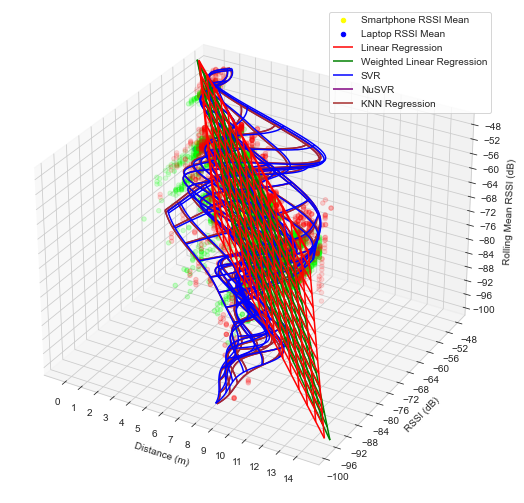

In [23]:
# Now let's plot the results
# Define a figure and its plot size
fig = plt.figure(figsize=(16,9))
# Add a subplot to the figure and make it 3D
ax = fig.add_subplot(111, projection='3d')

# The scatter plot for the data collected for the smartphone in transparent red
ax.scatter(y_smartphone, X_smartphone[:,0], X_smartphone[:,1], c='#ff00003f')
# The scatter plot the data collected for the laptop transparent green
ax.scatter(y_laptop, X_laptop[:,0], X_laptop[:,1], c='#00ff003f')

# Plot the points that mark the mean RSSI recorded by the smartphone for a given distance (yellow).
ax.scatter(data_plot_smartphone_means.distance,
           data_plot_smartphone_means.rssi,
           data_plot_smartphone_means.rolling_mean_rssi,
           c='yellow', label='Smartphone RSSI Mean')

# Plot the points that mark the mean RSSI recorded by the laptop for a given distance (blue).
ax.scatter(data_plot_laptop_means.distance,
           data_plot_laptop_means.rssi,
           data_plot_laptop_means.rolling_mean_rssi,
           c='blue', label='Laptop RSSI Mean')

# Plot the prediction plane for linear regression in red
ax.plot_wireframe(linear_regression_predictions, X_rssi, X_rolling_mean_rssi, color='red', rcount=15, ccount=15, label='Linear Regression')
# Plot the prediction plane for linear regression in blue
ax.plot_wireframe(weighted_linear_regression_predictions, X_rssi, X_rolling_mean_rssi, color='green', rcount=15, ccount=15, label='Weighted Linear Regression')
# Plot the prediction surface for SVR in green
ax.plot_wireframe(svr_predictions, X_rssi, X_rolling_mean_rssi, color='blue', rcount=15, ccount=15, label='SVR')
# Plot the prediction surface for NuSVR in purple
ax.plot_wireframe(nusvr_predictions, X_rssi, X_rolling_mean_rssi, color='purple', rcount=15, ccount=15, label='NuSVR')
# Plot the prediction surface for KNN Regression in brown
ax.plot_wireframe(nusvr_predictions, X_rssi, X_rolling_mean_rssi, color='brown', rcount=15, ccount=15, label='KNN Regression')

# Set the X axis between the distance minimum -1 and the distance maximum +1 
ax.set_xlim(y.min()-1, y.max()+5)
# Set the Y axis ticks between the RSSI minimum -1 and the RSSI maximum +1 
ax.set_ylim(X.min()-1, X.max()+1)
# Set the Z axis ticks between the RSSI minimum -1 and the RSSI maximum +1 
ax.set_zlim(X.min()-1, X.max()+1)

# Set the X axis ticks between the disance minimum -1 and the distance maximum +5 
ax.set_xticks(np.arange(y.min(), y.max()+5, 1.0))
# Set the Y axis ticks between the RSSI minimum -1 and the RSSI maximum +1 
ax.set_yticks(np.arange(X.min(), X.max()+1, 4.0))
# Set the Z axis ticks between the RSSI minimum -1 and the RSSI maximum +1 
ax.set_zticks(np.arange(X.min(), X.max()+1, 4.0))

# Set the X axis label
ax.set_xlabel('Distance (m)')
# Set the Y axis label
ax.set_ylabel('RSSI (dB)')
# Set the Z axis label
ax.set_zlabel('Rolling Mean RSSI (dB)')

# Enable the grid
ax.grid(True)
# Show the legent at the best place
ax.legend(loc='best');

# Show the plot
plt.show()

### Cross Validated Predictions

In [24]:
# Now let's thake the best estimator that was found with GridSearchCV for each algorithm and put them to the test.
# These estimators should already be parametrized with the best parameters and we will retrain using cross validation
# just like before and perform predictions on the data that is kept for testing on each fold. We store the predicted
# distances and then store the difference to the real ones on a dedicate column in order to compute summarize statistics.

# Linear Regression
data_plot_test['linear_regression_results_3d'] = cross_val_predict(linear_regression_grid.best_estimator_, X_test, y_test,
                                                         # The split is the same we used previously for GridSearchCV 
                                                         cv=StratifiedKFold(n_splits=n_splits, shuffle=True,
                                                                            random_state=random_state).split(X_test, y_labels_test))
data_plot_test['linear_regression_error_3d'] = np.abs(data_plot_test['linear_regression_results_3d'] - data_plot_test['distance'])

# Weighted Linear Regression
data_plot_test['weighted_linear_regression_results_3d'] = cross_val_predict(weighted_linear_regression_grid.best_estimator_, X_test, y_test,
                                                                  # The split is the same we used previously for GridSearchCV
                                                                  cv=StratifiedKFold(n_splits=n_splits, shuffle=True,
                                                                                     random_state=random_state).split(X_test, y_labels_test),
                                                                  fit_params = { 'regression__sample_weight': X_weight_test })
data_plot_test['weighted_linear_regression_error_3d'] = np.abs(data_plot_test['weighted_linear_regression_results_3d'] - data_plot_test['distance'])

# SVR
data_plot_test['svr_results_3d'] = cross_val_predict(svr_grid.best_estimator_, X_test, y_test.ravel(),
                                                     cv=StratifiedKFold(n_splits=n_splits, shuffle=True,
                                                                        random_state=random_state).split(X_test, y_labels_test))
data_plot_test['svr_error_3d'] = np.abs(data_plot_test['svr_results_3d'] - data_plot_test['distance'])

# NuSVR
data_plot_test['nusvr_results_3d'] = cross_val_predict(nusvr_grid.best_estimator_, X_test, y_test.ravel(),
                                             cv=StratifiedKFold(n_splits=n_splits, shuffle=True,
                                                                random_state=random_state).split(X_test, y_labels_test))
data_plot_test['nusvr_error_3d'] = np.abs(data_plot_test['nusvr_results_3d'] - data_plot_test['distance'])

# KNN Regression
data_plot_test['knnr_results_3d'] = cross_val_predict(knnr_grid.best_estimator_, X_test, y_test.ravel(),
                                             cv=StratifiedKFold(n_splits=n_splits, shuffle=True, 
                                                                random_state=random_state).split(X_test, y_labels_test))
data_plot_test['knnr_error_3d'] = np.abs(data_plot_test['knnr_results_3d'] - data_plot_test['distance'])

# The error percentiles we are interested in
error_percentiles = [0.25, 0.5, 0.75, 0.9, 0.95, 0.99]
# Get the distance error indicators
errors = data_plot_test[['linear_regression_error', 'linear_regression_error_3d',
                         'weighted_linear_regression_error', 'weighted_linear_regression_error_3d',
                         'svr_error', 'svr_error_3d',
                         'nusvr_error', 'nusvr_error_3d',
                         'knnr_error', 'knnr_error_3d']].describe(error_percentiles)
# Save them
errors.to_excel('out/beacon-errors.xlsx')
# Show them
errors

,linear_regression_error,linear_regression_error_3d,weighted_linear_regression_error,weighted_linear_regression_error_3d,svr_error,svr_error_3d,nusvr_error,nusvr_error_3d,knnr_error,knnr_error_3d
count,2441.000000,2441.000000,2441.000000,2441.000000,2441.000000,2441.000000,2441.000000,2441.000000,2441.000000,2441.000000
mean,1.180451,1.177099,1.180844,1.179827,1.083565,0.982570,1.089369,0.981912,1.064256,0.951336
std,0.892498,0.889704,0.893152,0.894036,0.803559,0.812161,0.799165,0.814978,0.798922,0.816380
min,0.000203,0.000288,0.001954,0.001048,0.000205,0.000519,0.000610,0.000255,0.000000,0.000000
25%,0.474677,0.472249,0.480601,0.494314,0.472351,0.382660,0.537044,0.367837,0.381295,0.303030
50%,1.035639,1.029128,1.037650,1.010900,0.981893,0.822213,0.957437,0.825483,0.964029,0.787879
75%,1.680271,1.673085,1.664868,1.658892,1.459003,1.370165,1.466280,1.372593,1.438849,1.333333
90%,2.374523,2.345000,2.374785,2.365774,2.050489,1.888245,2.056789,1.894597,2.057554,1.924242
95%,2.763911,2.809328,2.795694,2.898492,2.558510,2.512386,2.557447,2.516377,2.561151,2.530303
99%,4.052874,3.968505,4.029083,3.827023,3.738419,3.856969,3.719090,3.859796,3.781295,3.727273


# Other experiments

## Trying to find a better RSSI threshold for YanuX Broker's built-in proximity sensing system

In [25]:
# Assuming that we want to detect when something is at least this number of meters away from another thing
distance_threshold = 5.0
# We prepare a table from our input data with only the distance, rssi and avgRssi columns since we we will not look into any other details for now.
table = data[['distance', 'avgRssi', 'rssi']]

# Now we filter the table to only include data from the distance we are interested in and further away. We also chop the result so that we only have the rssi and avgRssi columns to work with.
filtered_table = table[table['distance'] >= distance_threshold][['rssi', 'avgRssi']]
filtered_table.describe(percentiles=[0.01, 0.05, 0.10, 0.25, 0.50, 0.75, 0.90, 0.95, 0.99])

,rssi,avgRssi
count,4218.000000,4218.000000
mean,-72.003319,-71.952569
std,6.596683,4.523872
min,-100.000000,-92.714286
1%,-92.000000,-82.037639
5%,-85.000000,-78.224183
10%,-81.000000,-77.529412
25%,-76.000000,-75.676471
50%,-71.000000,-71.875000
75%,-67.000000,-68.293750


In [26]:
# Let's just try the reverse
filtered_table_reverse = table[table['distance'] < distance_threshold][['rssi', 'avgRssi']]
filtered_table_reverse.describe(percentiles=[0.01, 0.05, 0.10, 0.25, 0.50, 0.75, 0.90, 0.95, 0.99])

,rssi,avgRssi
count,3916.000000,3916.000000
mean,-60.133555,-60.117148
std,6.182767,5.314149
min,-87.000000,-74.000000
1%,-75.000000,-70.707143
5%,-73.000000,-68.500000
10%,-69.000000,-67.520000
25%,-64.000000,-63.761905
50%,-59.000000,-60.444444
75%,-57.000000,-57.692308


In [27]:
filtered_table['avgRssi'].quantile(0.95)

-64.94692982456141

In [28]:
filtered_table_reverse['avgRssi'].quantile(0.05)

-68.5

In [29]:
selected_threshold = -65

In [30]:
stats.percentileofscore(filtered_table['avgRssi'].dropna(), selected_threshold)

94.53532479848269

In [31]:
stats.percentileofscore(filtered_table_reverse['avgRssi'].dropna(), selected_threshold)

18.30949948927477

In [32]:
scores = pd.DataFrame({"rssi":[], "moreThanOrEqual":[], "lessThan": []}) 

for rssi in np.arange(min(table['rssi'].min(), table['avgRssi'].min()), max(table['rssi'].max(), table['avgRssi'].max())):
    row = pd.DataFrame({"rssi":[rssi], 
                        "moreThanOrEqual":[stats.percentileofscore(filtered_table['avgRssi'].dropna(), rssi)], 
                        "lessThan": [stats.percentileofscore(filtered_table_reverse['avgRssi'].dropna(), rssi)]})
    scores = scores.append(row)

scores

,rssi,moreThanOrEqual,lessThan
0,-100.0,0.000000,0.000000
0,-99.0,0.000000,0.000000
0,-98.0,0.000000,0.000000
0,-97.0,0.000000,0.000000
0,-96.0,0.000000,0.000000
0,-95.0,0.000000,0.000000
0,-94.0,0.000000,0.000000
0,-93.0,0.000000,0.000000
0,-92.0,0.189663,0.000000
0,-91.0,0.213371,0.000000


<AxesSubplot:xlabel='rssi'>

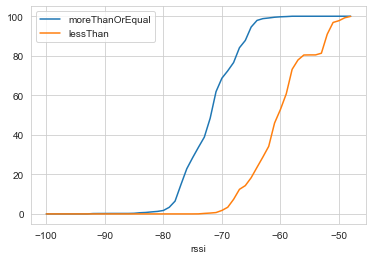

In [33]:
scores.plot(x='rssi', y=['moreThanOrEqual', 'lessThan'])